# Land Cover Classification using Deep Learning Techniques and EuroSAT

## Mounting google drive for dataset access and saving models

In [1]:
import importlib

try:
    drive = importlib.import_module('google.colab').drive
    drive.mount('/content/drive')
except ModuleNotFoundError:
    print('google.colab not available; skipping drive mount.')

google.colab not available; skipping drive mount.


## Libraries

In [2]:
import os
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

try:
    sns = importlib.import_module('seaborn')
except ModuleNotFoundError:
    sns = None
    print('seaborn not available; plots will be skipped.')

try:
    sklearn_metrics = importlib.import_module('sklearn.metrics')
    confusion_matrix = sklearn_metrics.confusion_matrix
except ModuleNotFoundError:
    confusion_matrix = None
    print('scikit-learn not available; confusion matrix will be skipped.')

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import transforms
from torchvision.utils import make_grid

c:\Users\sharm\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scikit-learn not available; confusion matrix will be skipped.


## Config

In [3]:
# Local dataset configuration
ROOT_PATH = r"C:/EuroSAT_RGB"  # folder containing class subfolders and FULL_DATA.csv
BASE_PATH = ROOT_PATH  # images live directly under this folder, in class-named subfolders
DATA_PATH = os.path.join(ROOT_PATH, 'Dataset')  # unused but kept for compatibility
FULL_DATA_DF = os.path.join(ROOT_PATH, 'FULL_DATA.csv')

if not os.path.isdir(ROOT_PATH):
    raise FileNotFoundError(f"Dataset root not found: {ROOT_PATH}")

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}
CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = {val: key for key, val in IDX_CLASS_LABELS.items()}

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1


## Utils

In [4]:
## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

## Show batches of images
def show_batch(dl):
    for images, _ in dl:
        _, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

In [5]:
## Example for decoding and encoding
print(encode_label('Forest'), decode_target(2))
print(decode_target(2, text_labels=True))

1 HerbaceousVegetation
HerbaceousVegetation


## Pre-Processing data folders to train and test
Run this code cells only if you don't have the required dataframe

In [6]:
# from os import walk
# i = 0
# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   print("Directory Path: ", dirpath)
#   print("Directory Name: ", dirname)
#   print("Filename : ", filename)
#   print("----------------------"*10)
#   i += 1
#   if i > 3:
#     break

In [7]:
# from os import walk

# i = 0
# DATA_DF = pd.DataFrame(columns = ['image_id', 'label']) 

# for (dirpath, dirname, filename) in walk(BASE_PATH):
#   for each_file in filename:
#     DATA_DF.loc[i] = [each_file, dirpath.split('/')[-1]]
#     i += 1
#   # break
# DATA_DF.to_csv(FULL_DATA_DF, index=False)
# DATA_DF.head()


## Processing data folders to train and test


In [8]:
DATA_DF = pd.read_csv(FULL_DATA_DF)
DATA_DF = DATA_DF.sample(frac = 1, random_state=48) 
TRAIN_DF = DATA_DF[:-int(len(DATA_DF)*VALID_SIZE)]
VALID_DF = DATA_DF[-int(len(DATA_DF)*VALID_SIZE) :]

In [9]:
TRAIN_DF.reset_index(inplace = True) 
TRAIN_DF.head()

,index,image_id,label
0,19127,Residential_1563.jpg,Residential
1,3197,Forest_1176.jpg,Forest
2,24557,SeaLake_150.jpg,SeaLake
3,17042,PermanentCrop_1937.jpg,PermanentCrop
4,3697,Forest_1626.jpg,Forest


In [10]:
VALID_DF.reset_index(inplace = True) 
VALID_DF.head()

,index,image_id,label
0,21985,River_1435.jpg,River
1,25621,SeaLake_2458.jpg,SeaLake
2,21573,River_1064.jpg,River
3,25070,SeaLake_1962.jpg,SeaLake
4,13947,Industrial_951.jpg,Industrial


In [11]:
TRAIN_DF.size, VALID_DF.size

(72900, 8100)

## Creating Dataset and Dataloaders

Now we will Create custom dataset by extending pytorch Dataset class. We also add provision for adding transformers for data augmentation.

In [12]:
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform
        
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img = Image.open(os.path.join(self.train_dir, img_id.split('.')[0].split('_')[0], img_id))
        if self.transform:
            img = self.transform(img)
        return img, encode_label(label)

### Transformations and Datasets

In [13]:
## Dataset and transformations
data_transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
train_ds = EuroSAT(TRAIN_DF, BASE_PATH, data_transform)
valid_ds = EuroSAT(VALID_DF, BASE_PATH, data_transform)
print(len(train_ds), len(valid_ds))

24300 2700


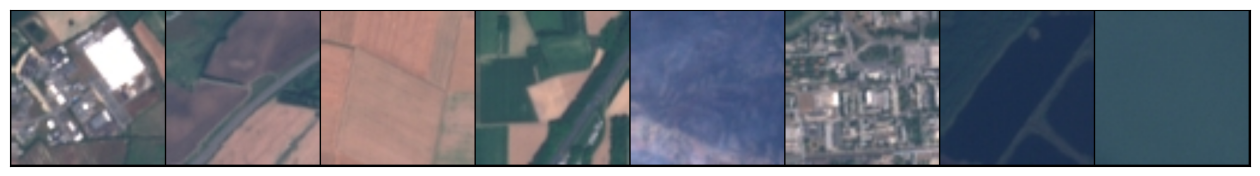

In [14]:
## Data loaders and showing batch of data (CPU quick preview)
batch_size = 8  # smaller to reduce per-batch work
train_preview = Subset(train_ds, range(min(128, len(train_ds))))
valid_eval = Subset(valid_ds, range(min(256, len(valid_ds))))
train_dl = DataLoader(train_preview, batch_size, shuffle=True, num_workers=0, pin_memory=False)
valid_dl = DataLoader(valid_eval, batch_size, shuffle=False, num_workers=0, pin_memory=False)
show_batch(train_dl)

## Model

In [15]:
criterion = nn.CrossEntropyLoss()

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

class MulticlassClassifierBase(nn.Module):
    
    def training_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return accu ,loss
    def validation_step(self, batch):
        img, label = batch
        out = self(img)
        loss = criterion(out, label)
        accu = accuracy(out, label)
        return {"val_loss": loss.detach(), "val_acc": accu}
    
    def validation_epoch_ends(self, outputs):
        batch_loss = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss":epoch_loss.item(), "val_acc":epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_accu: {:.4f}, learning_rate: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,result['train_accu'], result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
class LULC_Model(MulticlassClassifierBase):
    def __init__(self):
        super().__init__()
        try:
            weights = models.ResNet18_Weights.DEFAULT
            self.network = models.resnet18(weights=weights)
        except Exception as e:
            print(f'Warning: pretrained ResNet18 weights unavailable ({e}); using random init.')
            self.network = models.resnet18(weights=None)
        n_inputs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(256, NUM_CLASSES),
                              nn.LogSoftmax(dim=1)
                                )
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad = False
        for param in self.network.fc.parameters():
            param.requires_grad = True
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad = True

In [17]:
model = LULC_Model()

In [18]:
## Running through the data loader => Model => Output
def try_batch(dl):
    for images, _ in dl:  
        print(images.shape)
        out = model(images)
        print(out.shape)
        print(out[0])
        break
try_batch(train_dl)

torch.Size([8, 3, 224, 224])
torch.Size([8, 10])
tensor([-2.1114, -2.2012, -2.2853, -2.0928, -2.2125, -2.5335, -2.2873, -2.2825,
        -2.7324, -2.4566], grad_fn=<SelectBackward0>)


## Training and Evaluating

In [19]:
@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_loader]
    return model.validation_epoch_ends(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, max_lr,  model, train_loader, valid_loader, weight_decay=0,\
                grad_clip=None,opt_func=torch.optim.SGD, max_epochs_stop=3):
  
    history = []
    valid_loss_min = float('inf')
    valid_acc_max = 0.0
    model_file_name = 'lulc.pth'
    model_file_name2 = 'lulc_max_acc.pth'
    epochs_no_improve =  0
    optimizer = opt_func(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.00001)
                         
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_accu = []
        lrs = []
        # Plain iterator to avoid tqdm/IPyWidgets issues on some notebook setups
        for batch in train_loader:
            
            accu, loss = model.training_step(batch)
            train_loss.append(loss)
            train_accu.append(accu)
            loss.backward()
            ## Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            
            
            
        result = evaluate(model, valid_loader)
        scheduler.step(result['val_loss'])
        ########### Early Stopping ##############                                         
        valid_loss = result['val_loss']
        valid_acc = result['val_acc']
        if valid_acc > valid_acc_max:
            torch.save(model.state_dict(), model_file_name2)
            valid_acc_max = valid_acc
        if valid_loss<valid_loss_min:
            torch.save(model.state_dict(), model_file_name)
            valid_loss_min = valid_loss                                  
            epochs_no_improve = 0          
        else:
            epochs_no_improve += 1
            if epochs_no_improve > max_epochs_stop:
                result["train_loss"] = torch.stack(train_loss).mean().item()
                result["train_accu"] = torch.stack(train_accu).mean().item()
                result["lrs"] = lrs
                model.epoch_end(epoch, result)
                history.append(result)
                print("Early Stopping............................")
                return history                                
                                                 
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["train_accu"] = torch.stack(train_accu).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    print("VAL LOSS MIN {}".format(valid_loss_min))
    print("VAL ACC MAX {}".format(valid_acc_max))
    return history

## Initializing Device also Loading Data and Model to device¶


In [20]:
def get_device():
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [21]:
device = get_device()
## Loading data to devide
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
## Loading model to device
model = to_device(LULC_Model(), device)
## lets try passing a batch to model again
try_batch(train_dl)

False
torch.Size([8, 3, 224, 224])
torch.Size([8, 10])
tensor([-2.1992, -2.5947, -2.3252, -2.2953, -3.0206, -2.5764, -2.0125, -2.0354,
        -1.7324, -2.9957], grad_fn=<SelectBackward0>)


In [22]:
torch.cuda.empty_cache()

## Training

In [23]:
## Hyper Parameters (CPU)
max_epochs_stop = 10
max_lr = 1e-4
grad_clip = 0.1
weight_decay = 1e-3
batch_size = 16  # stays in sync with the loaders above
criterion = nn.CrossEntropyLoss()
epochs = 5  # shorter for CPU
opt_func = torch.optim.Adam
## Evaluating with non-trained model on small valid subset (CPU)
evaluate(model, valid_dl)

{'val_loss': 2.288816452026367, 'val_acc': 0.0703125}

In [24]:
## Freezing except last layer
model.freeze()
## Training
history = fit(epochs, max_lr, model, train_dl, valid_dl, weight_decay, grad_clip, opt_func, max_epochs_stop)

Epoch [0],train_accu: 0.1797, learning_rate: 0.0001, train_loss: 2.2563, val_loss: 2.2789, val_acc: 0.1172
Epoch [1],train_accu: 0.1641, learning_rate: 0.0001, train_loss: 2.2379, val_loss: 2.2486, val_acc: 0.1211
Epoch [2],train_accu: 0.2812, learning_rate: 0.0001, train_loss: 2.0875, val_loss: 2.1789, val_acc: 0.1875
Epoch [3],train_accu: 0.2891, learning_rate: 0.0001, train_loss: 2.0845, val_loss: 2.1291, val_acc: 0.3164
Epoch [4],train_accu: 0.3203, learning_rate: 0.0001, train_loss: 2.0123, val_loss: 2.0710, val_acc: 0.3672
VAL LOSS MIN 2.071044683456421
VAL ACC MAX 0.3671875


## Reports

### Training Reports

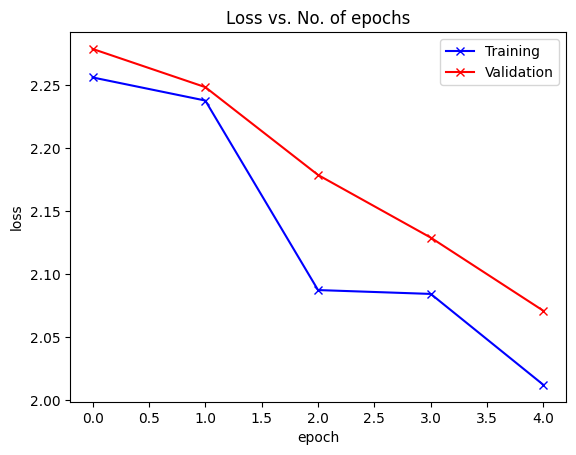

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

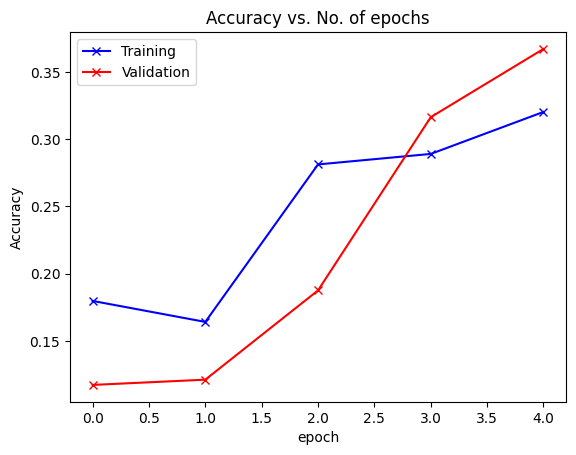

In [26]:
def plot_accuracy(history):
        
    train_accu = [x.get('train_accu') for x in history]
    val_accu = [x['val_acc'] for x in history]
    plt.plot(train_accu, '-bx')
    plt.plot(val_accu, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracy(history)

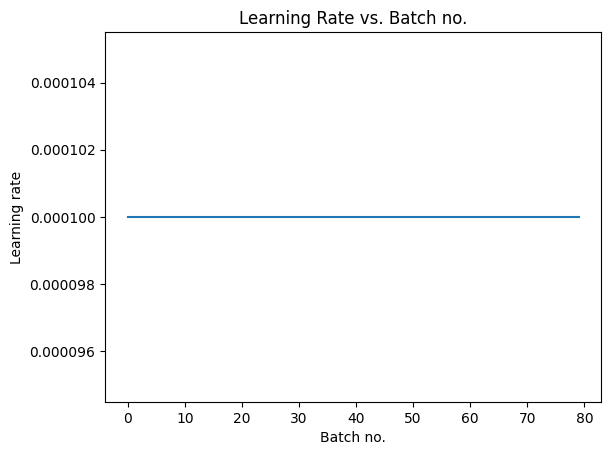

In [27]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
    
plot_lrs(history)

### Prediction Reports

In [28]:
def show_sample(img, target=None):
    if target:
        print("Label" ,decode_target(int(target), text_labels=True))
    plt.imshow(img.permute(1, 2, 0))

### Predict Single Images
def predict_single(image):
    show_sample(image)
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    _, prediction = torch.max(preds.cpu().detach(), dim=1)
    return decode_target(int(prediction), text_labels=True)


'PermanentCrop'

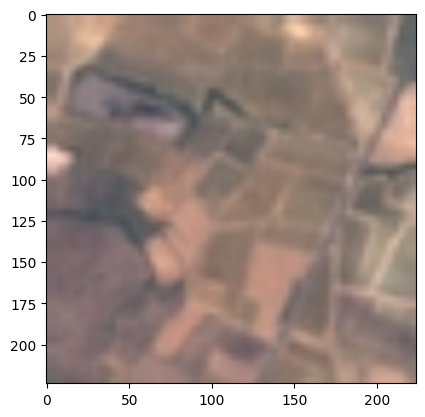

In [29]:
predict_single(valid_ds[40][0])

'Highway'

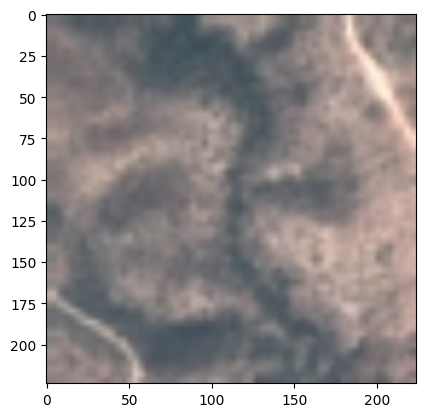

In [30]:
predict_single(valid_ds[30][0])

'Highway'

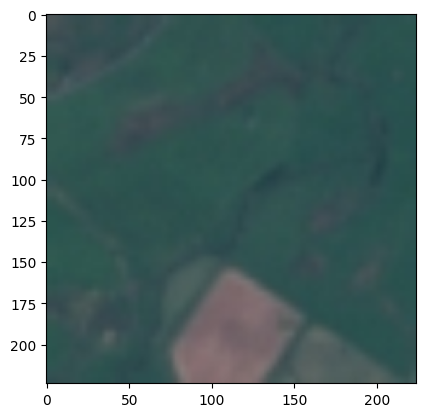

In [31]:
predict_single(valid_ds[90][0])

## Evaluation on whole dataset

In [32]:
batch_size =1
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_pred, labels = [], []
    for xb, label in tqdm(dl):
        probs = model(xb)
        _, pred = torch.max(probs.cpu().detach(), dim=1)
        batch_pred.append(pred.cpu().detach())     
        labels.append(label)   
    return [x for x in batch_pred], \
            [x for x in labels]

In [33]:

## Accuracy Evaluation
def final_accuracy(predictions, labels):
  predictions = to_device(predictions, device)
  labels = to_device(labels, device)
  ## Total Accuracy
  total = 0
  for i in range(len(predictions)):
    if predictions[i] == labels[i]:
      total += 1
  acc = total/len(predictions)
  print(acc)

In [34]:
full_ds = EuroSAT(DATA_DF, BASE_PATH, data_transform)
full_dl = DataLoader(full_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
device = get_device()
## Loading data to devide
full_dl = DeviceDataLoader(full_dl, device)


False


In [35]:
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm

  0%|          | 0/27000 [00:00<?, ?it/s]c:\Users\sharm\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 14%|█▍        | 3721/27000 [03:36<22:32, 17.21it/s]


KeyboardInterrupt: 

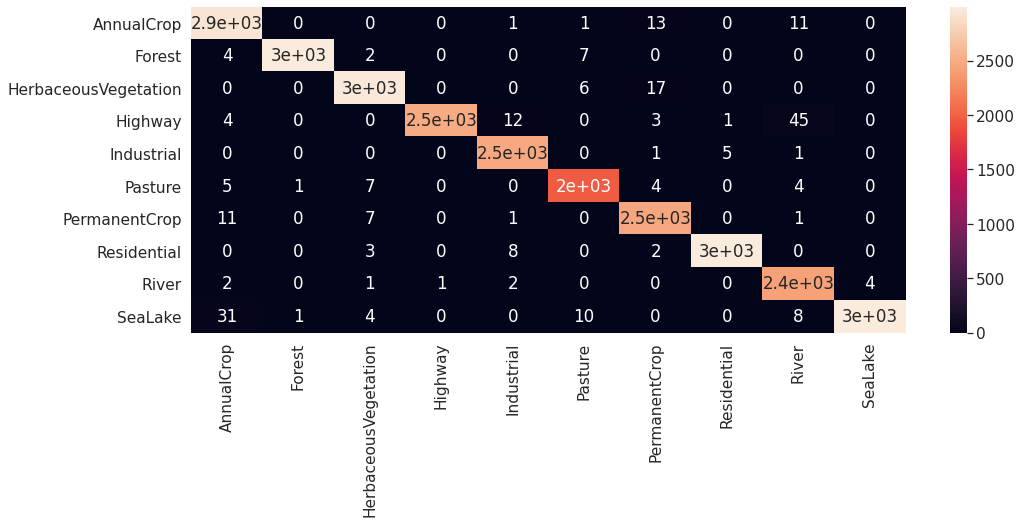

In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
if sns:
    sns.set_theme(font_scale=1.4)  # for label size
    plt.figure(figsize = (16,6))
    sns.heatmap(df_cm, annot=True)

In [ ]:
## Evaluation with best validation accuracy model
model = LULC_Model()
model.load_state_dict(torch.load("lulc_max_acc.pth", map_location='cpu'))
model.eval()
model = to_device(model, device)
predictions, labels = predict_dl(full_dl, model)
final_accuracy(predictions, labels)
preds = [x.item() for x in predictions]
labs = [x.item() for x in labels]
cm = confusion_matrix(preds, labs)
cm


0.9912592592592593


array([[2942,    0,    0,    0,    1,    2,   12,    0,    9,    0],
       [   4, 2999,    2,    0,    0,    9,    0,    0,    0,    0],
       [   0,    0, 2983,    0,    0,    7,   17,    0,    0,    0],
       [   5,    0,    0, 2498,   14,    0,    3,    2,   36,    0],
       [   0,    0,    0,    0, 2477,    0,    1,    6,    1,    0],
       [   6,    0,    6,    0,    0, 1972,    4,    0,    2,    0],
       [  12,    0,    6,    0,    1,    0, 2461,    0,    0,    0],
       [   0,    0,    0,    0,    3,    0,    2, 2992,    0,    0],
       [   3,    0,    1,    2,    4,    1,    0,    0, 2444,    4],
       [  28,    1,    2,    0,    0,    9,    0,    0,    8, 2996]])

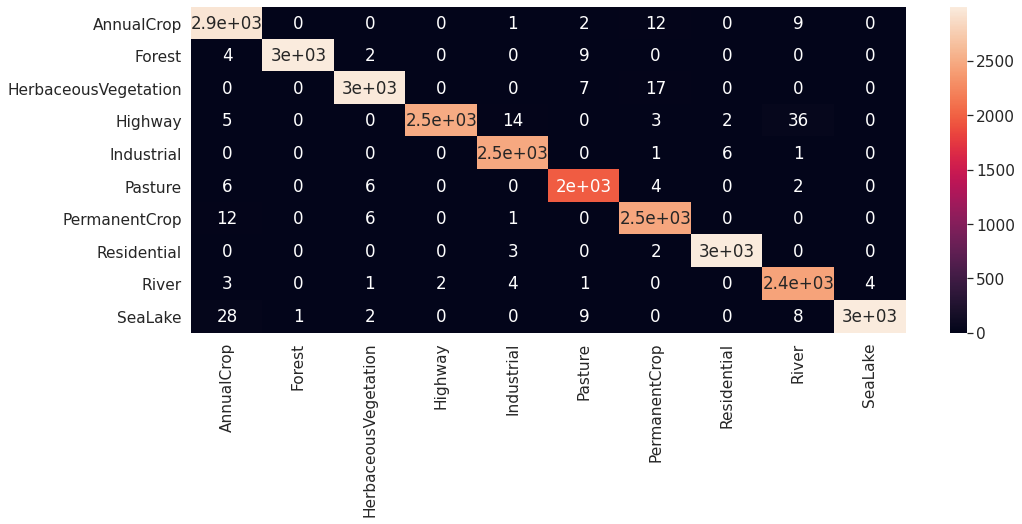

In [ ]:
## Plotting Confusion matrix
df_cm = pd.DataFrame(cm, CLASSES, CLASSES)
if sns:
    sns.set_theme(font_scale=1.4)  # for label size
    plt.figure(figsize = (16,6))
    sns.heatmap(df_cm, annot=True)